In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Датасет - "Авито: объявления о продаже собак и кошек"

In [6]:
data = pd.read_excel('avito_new_data_for_dano.xlsx')


In [9]:
data.columns
fig_width = 6.3  # Ширина
fig_height = 3.54  # Высота
plt.figure(figsize=(fig_width, fig_height), dpi=300)

<Figure size 1890x1062 with 0 Axes>

<Figure size 1890x1062 with 0 Axes>

In [42]:
data = data[(data['seller_rating'] != 0) & (data['seller_rating'].notna())].reset_index(drop=True)
y = data['contacts'] #сколько покупателей начали чат или посмотрели номер телефона
x1 = data['seller_rating']#Рейтинг продавца, NaN при отсутствии данных
x2 = data['description_word_count']#Количество слов в описании

In [86]:

with open('x1_list.txt', 'w') as f:
    for a in x1:
        
        f.write(str(a) + '\n')

## Регрессионный анализ
1) Одномерная линейная регрессия

In [13]:
def getPredY(x, a_star, b_star):
  return x*a_star+b_star

def getR(x, y, a_star, b_star):
  Sample_Ave=np.mean(y)
  y_pred=a_star*x+b_star
  numerator=np.sum((y-y_pred)**2)
  denominator=np.sum((y-Sample_Ave)**2)
  R=1-numerator/denominator
  return R

def getEstimates(x ,y, N):
  sum_x=0.0
  sum_y=0.0
  sum_xy=0.0
  sum_xx=0.0

  for i in range(N):
    sum_x += x.iloc[i]  #обращение по номеру а не по индексу
    sum_y += y.iloc[i]
    sum_xy += x.iloc[i] * y.iloc[i]
    sum_xx += x.iloc[i] * x.iloc[i]

  a_star=(N*sum_xy-sum_x*sum_y)/(N*sum_xx-sum_x**2)
  b_star=(sum_xx*sum_y-sum_x*sum_xy)/(N*sum_xx-sum_x**2)

  return [a_star, b_star]

In [22]:
a_star, b_star = getEstimates(x1, y, len(y))
print(f"Коэффициенты: a* = {a_star:.3f}, b* = {b_star:.3f}\n")
R2 = getR(x1, y, a_star, b_star)# коэффициент детерминации измеряет, насколько хорошо одна переменная объясняет вариацию другой
print(f" R^2 = {R2}")

Коэффициенты: a* = -0.149, b* = 3.106

 R^2 = 0.00013608743585979965


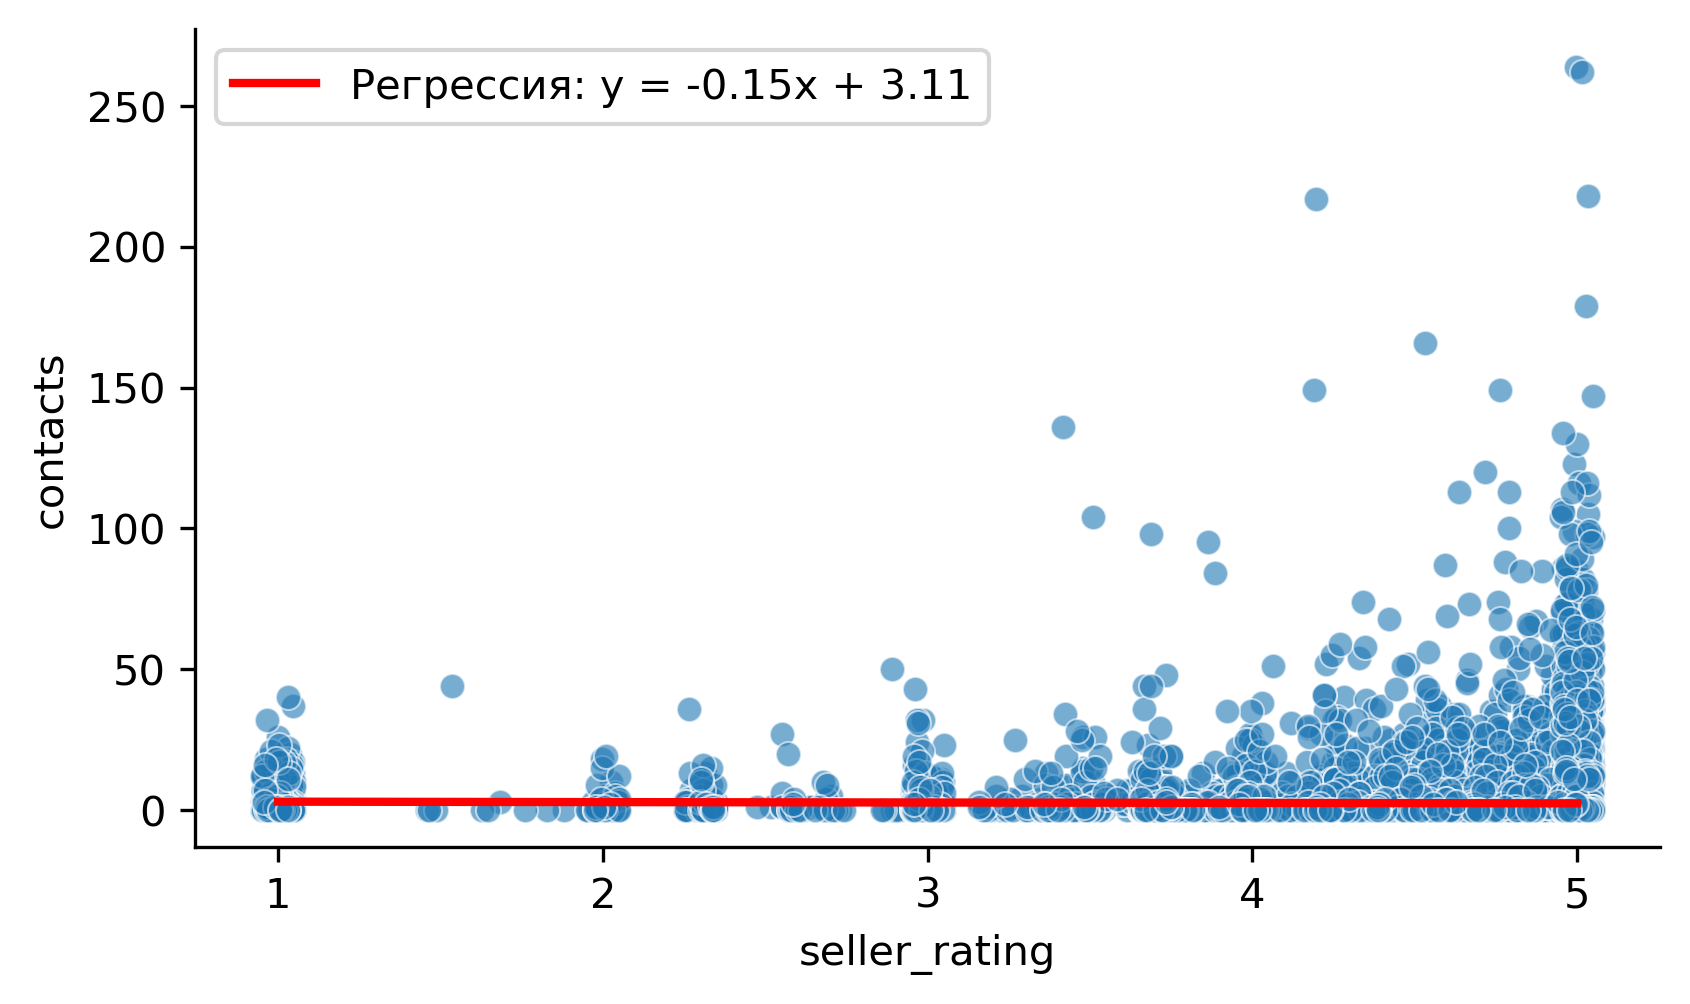

In [24]:
plt.figure(figsize=(fig_width, fig_height), dpi=300)
sns.scatterplot(x=x1 + np.random.uniform(-0.05, 0.05, size=len(y)), y=y, alpha=0.6)
x_line = np.linspace(min(x1), max(x1), 100)
y_line = a_star * x_line + b_star
plt.plot(x_line, y_line, color='red', linewidth=2, 
         label=f'Регрессия: y = {a_star:.2f}x + {b_star:.2f}')
plt.legend()

sns.despine()



## Квадратичная регрессия (так как зависимость похожа на не линейную)

y=ax^2+bx+c

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

poly = PolynomialFeatures(degree=2, include_bias=False)  #создание полиномиальных признаков, последнее это создание первого столбца из единиц
x1_2 = np.array(x1).reshape(-1, 1) # reshape делает двумерный массив в котором каждая строка это элемент старого, а столбец 1
x1_poly = poly.fit_transform(x1_2)  # теперь в каждой строке элемент и его квадрат (обучили и приминили)
model = LinearRegression()
model.fit(x1_poly, y)

# Коэффициенты модели
print(f"a1, a2: {model.coef_}, b = {model.intercept_}")
y_pred = model.predict(x1_poly)
r2 = r2_score(y, y_pred)
print(f"R²: {r2}")


a1, a2: [ 0.21723326 -0.05236754], b = 2.5733992380464015
R²: 0.00016422579884001198


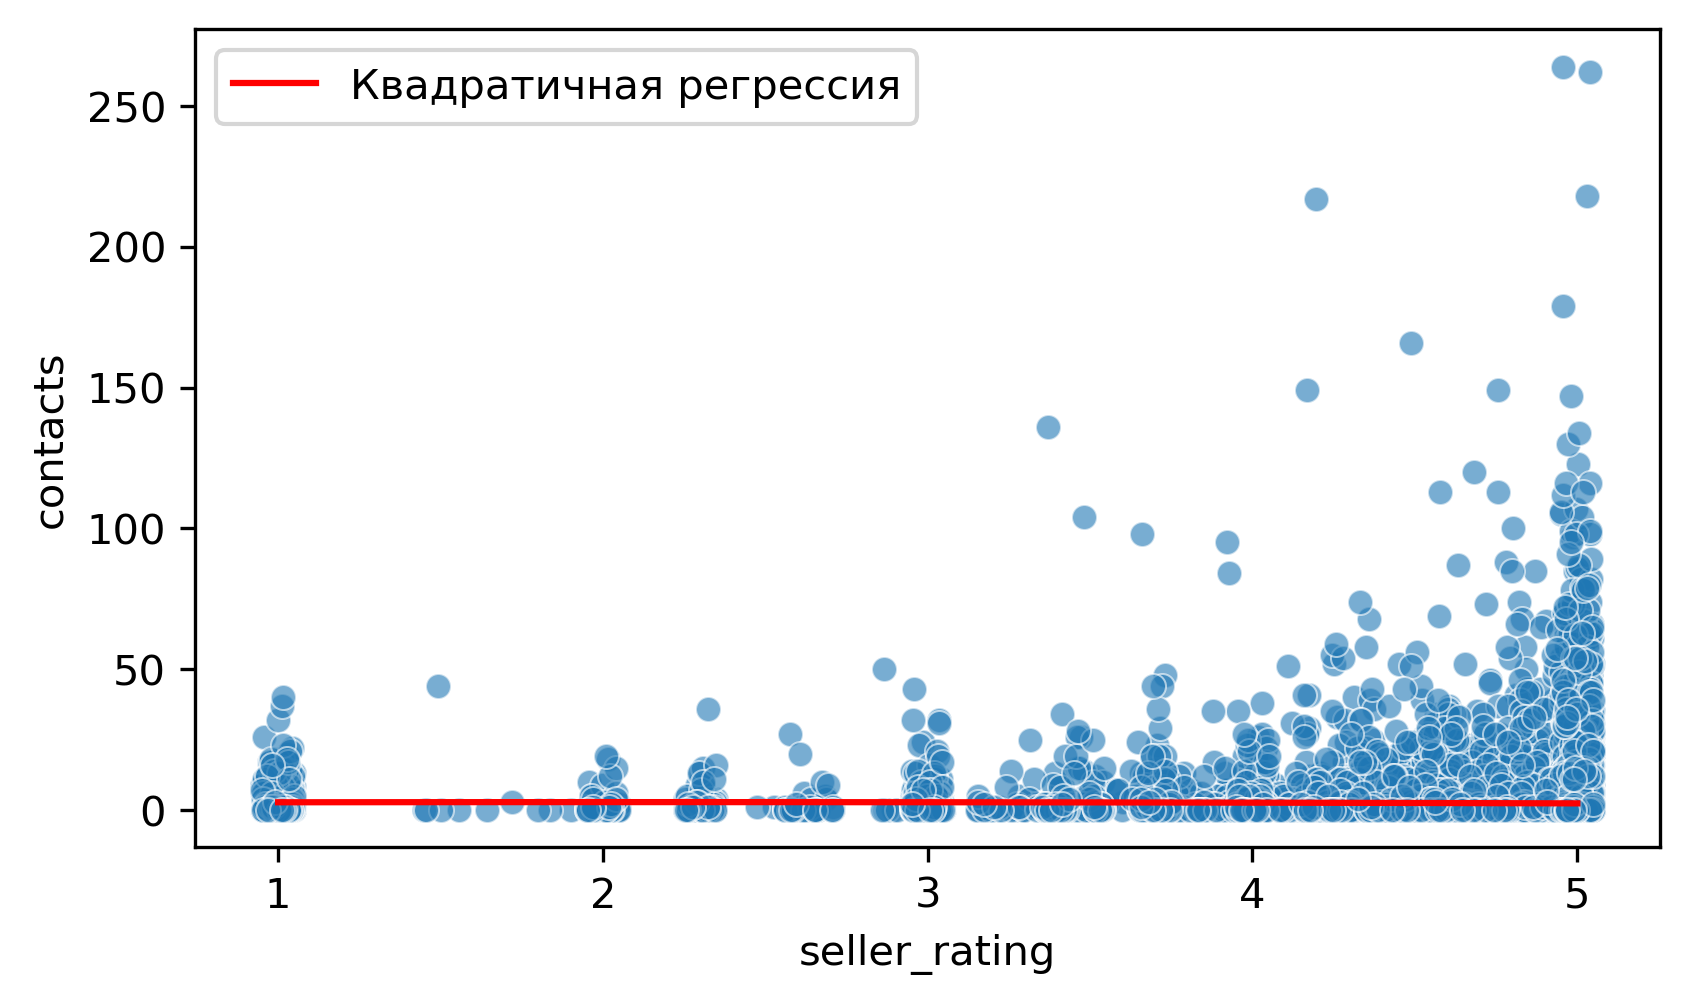

In [73]:
plt.figure(figsize=(fig_width, fig_height), dpi=300)
sns.scatterplot(x=x1 + np.random.uniform(-0.05, 0.05, size=len(y)), y=y, alpha=0.6)

x_plot = np.linspace(min(x1), max(x1), 100).reshape(-1, 1)
x_plot_poly = poly.transform(x_plot)  #создает вторую колонку с квадратами
y_plot = model.predict(x_plot_poly)
plt.plot(x_plot, y_plot, color='red', label='Квадратичная регрессия')
plt.legend()


R = 0,85 означает, что 85% вариации в оценках студентов объясняется количеством часов, проведенных на учебе. Остальные 15% вариации могут быть вызваны другими факторами, не учтенными в модели (например, индивидуальные способности, качество учебных материалов и т.д.)

## Двумерная линейная регрессия

In [161]:
def calculate_multi_reg(x1, x2, y_train):
   
    n = len(y_train)
    A = B = C = D = E = F = G = H = 0.0

    for i in range(n):
        A += x1[i]**2
        B += x1[i] * x2[i]
        C += x2[i]**2
        D += x1[i]
        E += x2[i]
        F += x1[i] * y_train[i]
        G += x2[i] * y_train[i]
        H += y_train[i]
        
    delta = A * (C * n - E * E) - B * (B * n - E * D) + D * (B * E - C * D)
    
    delta_a1 = F * (C * n - E * E) - B * (G * n - E * H) + D * (G * E - C * H)
    delta_a2 = A * (G * n - E * H) - F * (B * n - D * E) + D * (B * H - G * D)
    
    delta_b = A * (C * H - G * E) - B * (B * H - G * D) + F * (B * E - C * D)
    a1 = delta_a1/delta
    a2 = delta_a2/delta
    b = delta_b/delta
    y_mid = y_train/n
    y_pred=np.array([x1[i] * a1 + x2[i] * a2 + b for i in range (n)])
    u=sum(np.array([(y_train[i]-y_pred[i])**2 for i in range(n)]))
    v=sum(np.array([(y_train[i]-y_mid[i])**2 for i in range(n)]))
    R_sq = 1 - u/v
    return a1, a2, b, R_sq

In [163]:
a1_star, a2_star, b_star, R2 = calculate_multi_reg(x1, x2, y)
print(f"Коэффициенты: a1* = {a1_star:.3f}, a2* = {a2_star:.3f}, b* = {b_star:.3f}\n")
print(f" R^2 = {R2}")

Коэффициенты: a1* = -0.118, a2* = -0.009, b* = 3.381

 R^2 = 0.09441600748124235
